## Классификация заявок



Используется три архитектуры нейронных сетей:
- Одномерная сверточная нейросеть
- Рекуррентная нейросеть LSTM
- Рекуррентная нейросеть GRU


In [18]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

## Просматриваем данные

Читаем данные из файла

In [19]:
df = pd.read_excel('/content/exp.xlsx', index_col=1)
df['Описание запроса']=df['Описание запроса'].astype(str)

In [20]:
df


,Дата регистрации,Статус,Срочность,Тип объекта,Классификация,Контрагент,Описание запроса,Ответственный
Номер,,,,,,,,
18021,2020-07-17 09:30:00.357,Зарегистрирован,Низкая,Инцидент,Поддержка и сопровождения СЭД,Ушаков Артур Сергеевич/Комитет государственног...,Добрый день. \nПрошу отправить инструкции по н...,Дедловских Сергей Алексеевич/Информационная бе...
18020,2020-07-17 09:14:00.254,Зарегистрирован,Низкая,Инцидент,Управление доменными учетными записями,Человяга Сергей Анатольевич/Главное управление...,Консультант отдела контроля и лицензирования в...,Першин Леонид Валерьевич/Инфраструктура рабочи...
18015,2020-07-16 16:50:00.320,Зарегистрирован,Низкая,Инцидент,Поддержка операционных систем и базового прогр...,Электронная почта/Министерство информационных ...,Добрый день! \nГлавное управление гос. контрол...,Фролов Антон Сергеевич/Инфраструктура рабочих ...
18011,2020-07-16 15:18:00.308,Зарегистрирован,Низкая,Инцидент,Управление электронной почтой,Шипов Игорь Иванович/Управление лесами,"Просим заблокировать учетную запись Zimbra ""Ст...",Стрежнев Владимир Константинович/*Электронная ...
18010,2020-07-16 15:14:00.287,Закрыт,Низкая,Инцидент,Управление электронной почтой,Электронная почта/Министерство информационных ...,"Здравствуйте, \nпрошу восстановть доступ к поч...",Стрежнев Владимир Константинович/*Электронная ...
...,...,...,...,...,...,...,...,...
4769,2018-12-03 17:33:14.528,Закрыт,Низкая,Запрос на обслуживание,Сопровождение сетевого оборудования и сетей пе...,Костин Сергей Александрович/Министерство инфор...,Найти порты лини связи комм 2-4 этажей \nкаб 4...,Ким Сергей Сексенович/Инфраструктура рабочих мест
4768,2018-12-03 15:35:33.376,Закрыт,Низкая,Запрос на обслуживание,Обслуживание оргтехники,Алексей Сергеевич Ольшанский/Аппарат Губернато...,Переподкдючить компьютер из каб. 611 в каб.316б.,Першин Леонид Валерьевич/Инфраструктура рабочи...
4767,2018-12-03 14:58:00.484,Закрыт,Низкая,Инцидент,"Измени классификацию, кнопка справа",Артемьев Артем Сергеевич/Министерство культуры,по данной заявке никаких действий не предприня...,Первая линия техподдержки


Выделяем данные для обучения

In [28]:
desc = df['Описание запроса']

In [29]:
desc[:5]

Номер
18021    Добрый день. \nПрошу отправить инструкции по н...
18020    Консультант отдела контроля и лицензирования в...
18015    Добрый день! \nГлавное управление гос. контрол...
18011    Просим заблокировать учетную запись Zimbra "Ст...
18010    Здравствуйте, \nпрошу восстановть доступ к поч...
Name: Описание запроса, dtype: object

Выделяем правильные ответы

In [23]:
nb_classes = len(df['Классификация'].unique())

In [24]:
ohe = LabelEncoder()
Y = ohe.fit_transform(df['Классификация'])

In [25]:
y_train = to_categorical(Y - 1, nb_classes)

In [26]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Токенизация текста

Создаем токенизатор Keras

In [51]:
max_words = 10000
max_len = 30
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(desc)
sequences = tok.texts_to_sequences(desc)

Обучаем токенизатор на описаниях заявок


Просматриваем описание в числовом представлении

In [52]:
index = 6456
print(desc[index])
print(sequences[index])

не включается пк после перебоев со светом 
каб. 417, тел. 32-50-80
[39, 1438, 2957, 3, 956, 5, 175, 251]


In [53]:
tok.word_index['комп']

781

Ограничиваем длину отзывов

In [54]:
x_train = pad_sequences(sequences, maxlen=max_len)

In [55]:
x_train[:5]

array([[ 327,   77,  152, 2919,   90,   18, 3132, 1834,  290,   56,  134,
          15,  124,    1,   71,   33,   47,   38,  484,  192,   18,   11,
           6,    5,   26,   12,  135,  164,  102, 1315],
       [ 192, 7366,  365,  181,    2,    9,  260,   73,  184,   45,  105,
          71,   33,   51,   19,   65,   38,   35,    1,   48,   18,   11,
           6,  205,    5,   12,   13,   40,   49,  261],
       [1036, 3135,    8, 7370,   66, 4221, 5854,   16,  344,   40,  160,
         254,    8, 1099, 1836,    4,    3, 1142,  189,  208,   87,   68,
        5856,  645,    7,    2,    9, 2572,  291,   55],
       [  11,    6, 1650,  882,  961,  220,  322,   24,   21,   17,    5,
          12,   13,   89,  154,    7,    7,   12,   13,   30,   32,   53,
        1760,  413,    5,   41,  198,  623,  172,  264],
       [ 294,  100,  240,  699,  832,   11,    6,  831,   76,   76, 1319,
          24,   21,   17,  630,    5,   12,   13,   50,  404,  119, 1320,
           7,  413,    5,   41, 

## Сверточная нейронная сеть

In [56]:
model_cnn = Sequential()
model_cnn.add(Embedding(max_words, 32, input_length=max_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(25, activation='softmax'))

In [57]:
model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [58]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 32)            320000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 250)           40250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32128     
_________________________________________________________________
dense_3 (Dense)              (None, 25)                3225      
Total params: 395,603
Trainable params: 395,603
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [59]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [60]:
history_cnn = model_cnn.fit(x_train, 
                            y_train, 
                            epochs=7,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/7
69/71 [============================>.] - ETA: 0s - loss: 2.4869 - accuracy: 0.2354
Epoch 00001: val_accuracy improved from -inf to 0.48600, saving model to best_model_cnn.h5
71/71 [==============================] - 1s 9ms/step - loss: 2.4780 - accuracy: 0.2380 - val_loss: 1.8516 - val_accuracy: 0.4860
Epoch 2/7
70/71 [============================>.] - ETA: 0s - loss: 1.7488 - accuracy: 0.4797
Epoch 00002: val_accuracy improved from 0.48600 to 0.63500, saving model to best_model_cnn.h5
71/71 [==============================] - 1s 8ms/step - loss: 1.7466 - accuracy: 0.4804 - val_loss: 1.3270 - val_accuracy: 0.6350
Epoch 3/7
69/71 [============================>.] - ETA: 0s - loss: 1.3240 - accuracy: 0.6260
Epoch 00003: val_accuracy improved from 0.63500 to 0.67100, saving model to best_model_cnn.h5
71/71 [==============================] - 1s 8ms/step - loss: 1.3231 - accuracy: 0.6257 - val_loss: 1.1411 - val_accuracy: 0.6710
Epoch 4/7
65/71 [==========================>...] - ETA:

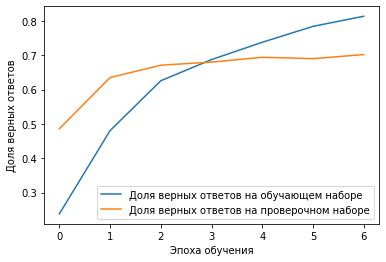

In [61]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть LSTM

In [63]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, 32, input_length=max_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(25, activation='softmax'))

In [64]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [65]:
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 32)            320000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense_4 (Dense)              (None, 25)                425       
Total params: 323,561
Trainable params: 323,561
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [66]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [69]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=15,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/15
69/71 [============================>.] - ETA: 0s - loss: 0.7911 - accuracy: 0.7895
Epoch 00001: val_accuracy did not improve from 0.66300
71/71 [==============================] - 1s 9ms/step - loss: 0.7905 - accuracy: 0.7898 - val_loss: 1.3019 - val_accuracy: 0.6580
Epoch 2/15
71/71 [==============================] - ETA: 0s - loss: 0.7646 - accuracy: 0.7969
Epoch 00002: val_accuracy improved from 0.66300 to 0.67100, saving model to best_model_lstm.h5
71/71 [==============================] - 1s 9ms/step - loss: 0.7646 - accuracy: 0.7969 - val_loss: 1.2818 - val_accuracy: 0.6710
Epoch 3/15
70/71 [============================>.] - ETA: 0s - loss: 0.7290 - accuracy: 0.8090
Epoch 00003: val_accuracy did not improve from 0.67100
71/71 [==============================] - 1s 9ms/step - loss: 0.7292 - accuracy: 0.8088 - val_loss: 1.3027 - val_accuracy: 0.6590
Epoch 4/15
70/71 [============================>.] - ETA: 0s - loss: 0.6961 - accuracy: 0.8154
Epoch 00004: val_accuracy did no

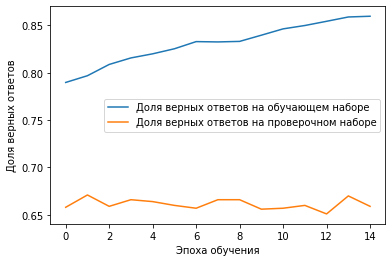

In [70]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Cеть GRU

In [76]:
model_gru = Sequential()
model_gru.add(Embedding(max_words, 32, input_length=max_len))
model_gru.add(GRU(16))
model_gru.add(Dense(25, activation='softmax'))

In [77]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [78]:
model_gru.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 32)            320000    
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense_6 (Dense)              (None, 25)                425       
Total params: 322,825
Trainable params: 322,825
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model_gru.h5`

In [79]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [82]:
history_gru = model_gru.fit(x_train, 
                              y_train, 
                              epochs=15,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/15
71/71 [==============================] - ETA: 0s - loss: 1.0128 - accuracy: 0.7178
Epoch 00001: val_accuracy did not improve from 0.65200
71/71 [==============================] - 1s 8ms/step - loss: 1.0128 - accuracy: 0.7178 - val_loss: 1.2679 - val_accuracy: 0.6470
Epoch 2/15
71/71 [==============================] - ETA: 0s - loss: 0.9463 - accuracy: 0.7348
Epoch 00002: val_accuracy improved from 0.65200 to 0.65600, saving model to best_model_gru.h5
71/71 [==============================] - 1s 9ms/step - loss: 0.9463 - accuracy: 0.7348 - val_loss: 1.2666 - val_accuracy: 0.6560
Epoch 3/15
68/71 [===========================>..] - ETA: 0s - loss: 0.8972 - accuracy: 0.7505
Epoch 00003: val_accuracy did not improve from 0.65600
71/71 [==============================] - 1s 9ms/step - loss: 0.8951 - accuracy: 0.7511 - val_loss: 1.2762 - val_accuracy: 0.6540
Epoch 4/15
70/71 [============================>.] - ETA: 0s - loss: 0.8474 - accuracy: 0.7644
Epoch 00004: val_accuracy did not

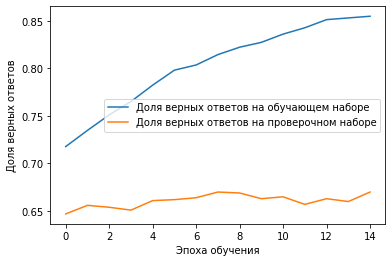

In [83]:
plt.plot(history_gru.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем набор данных для тестирования

In [86]:
test = pd.Series(['не работает вайз','проблема с принтером'])

In [87]:
test

0        не работает вайз
1    проблема с принтером
dtype: object

In [90]:
test_sequences = tok.texts_to_sequences(test)

In [91]:
x_test = pad_sequences(test_sequences, maxlen=max_len)

In [92]:
x_test[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   10,  117,  158],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  230,    2, 2516]], dtype=int32)

Правильные ответы

### Одномерная сверточная сеть 

In [97]:
model_cnn.load_weights(model_cnn_save_path)

In [98]:
model_cnn.predict(x_test)

array([[3.20917716e-05, 1.86148495e-03, 1.34387205e-03, 3.19789178e-05,
        1.71745967e-04, 3.50723480e-04, 5.95798119e-05, 9.83921418e-05,
        1.73136737e-04, 9.73659337e-01, 5.03910473e-03, 1.71603187e-06,
        5.16943354e-03, 9.60965932e-04, 7.03364424e-03, 3.01284902e-03,
        6.11838244e-04, 1.99788565e-06, 1.56489870e-04, 3.18525999e-05,
        5.52391721e-05, 3.52220894e-07, 4.14219699e-07, 1.51045015e-05,
        1.26633924e-04],
       [2.80018576e-04, 7.46420445e-03, 5.25131309e-03, 7.51142681e-04,
        3.87914188e-05, 4.83464124e-03, 8.86057736e-04, 1.27565174e-03,
        8.84536803e-01, 6.60227844e-03, 1.10218776e-02, 6.18654303e-05,
        1.85172353e-02, 8.23193882e-03, 1.27613591e-02, 5.25673677e-04,
        2.54615657e-02, 3.43985134e-03, 5.71555318e-03, 1.05270177e-04,
        7.02846388e-04, 5.83599649e-05, 1.06818124e-03, 1.10057910e-04,
        2.97478604e-04]], dtype=float32)